# Make the final SXDS catalogue

We want to take all the columns. We will save a catalogue for each patch which can be stacked to produce the final catalogues for serving publicly. The is_inner flags are used to remove the overlap regions. As far as possible we try to mimic the tables produced for HSC PDR2.

In [154]:
import os
import json
import numpy as np
import lsst.daf.persistence as dafPersist
import time
import gc

from astropy.table import Table, join, vstack
import astropy.units as u

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
hscBands = ['G', 'R', 'I', 'Z', 'Y']
vistaBands = ['Z', 'Y', 'J', 'H', 'Ks']
allBands = ['HSC-' +b for b in hscBands] + ['VISTA-' +b for b in vistaBands]

In [3]:
allBands

['HSC-G',
 'HSC-R',
 'HSC-I',
 'HSC-Z',
 'HSC-Y',
 'VISTA-Z',
 'VISTA-Y',
 'VISTA-J',
 'VISTA-H',
 'VISTA-Ks']

In [4]:
hscBands

['G', 'R', 'I', 'Z', 'Y']

In [5]:
os.getcwd()

'/Users/raphaelshirley/Documents/github/lsst-ir-fusion/dmu5/dmu5_VIDEO'

In [9]:
if os.getcwd().startswith('/Users/raphaelshirley/Documents/github'):
    BUTLER_LOC = '../../dmu4/dmu4_Example/data_g2'
    DATA =  './data'
else:
    BUTLER_LOC = '../../dmu4/dmu4_VIDEO/data'
    DATA =  './data'
butler =  dafPersist.Butler(inputs='{}/rerun/coaddPhot'.format(BUTLER_LOC))

In [10]:
BUTLER_LOC, DATA

('../../dmu4/dmu4_Example/data_g2', './data')

In [15]:
full_patch_dict = json.load(open('../../dmu4/dmu4_VIDEO/slurm/sxds_patch_job_dict_219.json', 'r'))

In [16]:
json.dumps(full_patch_dict)

'{"0": [8766, "5,1"], "1": [8766, "5,0"], "2": [8766, "3,2"], "3": [8766, "4,2"], "4": [8766, "0,3"], "5": [8766, "2,0"], "6": [8766, "1,0"], "7": [8766, "6,2"], "8": [8766, "0,0"], "9": [8766, "0,2"], "10": [8766, "1,2"], "11": [8766, "7,2"], "12": [8766, "3,0"], "13": [8766, "8,2"], "14": [8766, "1,3"], "15": [8766, "4,1"], "16": [8766, "2,3"], "17": [8766, "7,0"], "18": [8766, "6,0"], "19": [8766, "7,1"], "20": [8766, "5,2"], "21": [8766, "8,0"], "22": [8766, "3,3"], "23": [8766, "8,1"], "24": [8766, "2,1"], "25": [8766, "1,1"], "26": [8766, "2,2"], "27": [8766, "3,1"], "28": [8766, "0,1"], "29": [8766, "4,0"], "30": [8766, "6,1"], "31": [8524, "4,7"], "32": [8524, "5,3"], "33": [8524, "5,5"], "34": [8524, "7,7"], "35": [8524, "6,2"], "36": [8524, "1,6"], "37": [8524, "8,4"], "38": [8524, "5,7"], "39": [8524, "8,7"], "40": [8524, "1,2"], "41": [8524, "7,5"], "42": [8524, "3,2"], "43": [8524, "3,5"], "44": [8524, "4,2"], "45": [8524, "3,8"], "46": [8524, "1,5"], "47": [8524, "6,3"], 

In [24]:
def addFlux(cat, sources, photoCalib):
    """Add magnitudes and fluxes to an astropy catalogues with instrument fluxes"""
    for c in cat.colnames:
        if (c.endswith('_instFlux')):
            try:
                mags = photoCalib.instFluxToMagnitude(sources, c.replace('_instFlux',''))
                flux = photoCalib.instFluxToNanojansky(sources, c.replace('_instFlux',''))
                cat["{}_mag".format(c.replace('_instFlux',''))] = mags[:,0]
                cat["{}_mag".format(c.replace('_instFlux',''))].unit = u.mag
                cat["{}_mag".format(c.replace('_instFlux',''))].description = cat[c].description.replace(
                    'instFlux', 'mag')
                
                cat["{}_magErr".format(c.replace('_instFlux',''))] = mags[:,1]
                cat["{}_magErr".format(c.replace('_instFlux',''))].unit = u.mag
                cat["{}_magErr".format(c.replace('_instFlux',''))].description = cat[c].description.replace(
                    'instFlux', 'mag')
                
                cat["{}_flux".format(c.replace('_instFlux',''))] = flux[:,0]
                cat["{}_flux".format(c.replace('_instFlux',''))].unit = u.nJy
                cat["{}_flux".format(c.replace('_instFlux',''))].description = cat[c].description.replace(
                    'instFlux', 'flux')
                
                cat["{}_fluxErr".format(c.replace('_instFlux',''))] = flux[:,1]
                cat["{}_fluxErr".format(c.replace('_instFlux',''))].unit = u.nJy
                cat["{}_fluxErr".format(c.replace('_instFlux',''))].description = cat[c].description.replace(
                    'instFlux', 'flux')
            except:
                pass
    return cat

def makeCat(tract, patch, BUTLER_LOC,DATA=DATA,writeBandCats=True):
    """make the final catalogue on a given patch for later stacking"""
    cat =Table()
    tract = int(tract)
    for band in allBands:
        #We must keep columns under 68 characters by replacing long names
        mapping = { 
            'SecondDerivative':'SD', 
            'DoubleShapelet':'DS',
            'badCentroid':'BC',
            'badInitialCentroid':'BIC',
            'sincCoeffsTruncated':'SCT',
        }

        try:
            CoaddCalexp = butler.get('deepCoadd_calexp',  {'filter': band, 'tract': tract, 'patch': patch})
            CoaddPhotoCalib = CoaddCalexp.getPhotoCalib()
        
            measSources = butler.get('deepCoadd_meas', {'filter': band, 'tract': tract, 'patch': patch})
            measCat = measSources.asAstropy()
            measCat = addFlux(measCat, measSources, CoaddPhotoCalib)
            for c in measCat.colnames:    
                if c != 'id':
                    measCat[c].name = "{}_{}_{}".format(band,'m', c)
                
            forcedSources = butler.get('deepCoadd_forced_src', {'filter': band, 'tract': tract, 'patch': patch})
            forcedCat = forcedSources.asAstropy()
            forcedCat = addFlux(forcedCat, forcedSources, CoaddPhotoCalib)
            for c in forcedCat.colnames:    
                if c != 'id':
                    forcedCat[c].name = "{}_{}_{}".format(band,'f', c)
                    
            bandCat = join(measCat,forcedCat,join_type='outer')
            
            for c in bandCat.colnames:    
                if c != 'id':
                    newName = c
                    for k in mapping:
                        newName = newName.replace(k, mapping[k])
                    bandCat[c].name = newName
                    if len(newName)>68:
                        print('column name {} too long for fits writing.'.format(newName))
            if writeBandCats:
                bandCat.write(DATA+'/{}_{}_{}_fullCat.fits'.format(band,tract,patch), overwrite=True)
                
            if len(cat)==0:
                #On first band no join
                cat = bandCat
            else:
                #After first band join tables in
                cat = join(cat, bandCat,join_type='outer')
  
            
        except:
            warnings.warn("Band {} failed.".format(band))
                

    if len(cat) == 0:
        return None
    return cat.copy()

#makeCat(8524, '3,3', BUTLER_LOC)

In [25]:
cat = makeCat(8524, '3,5', BUTLER_LOC)
#cat[cat.colnames[0:999]].write(DATA+'/full_cat_{}_{}.fits'.format(8524, '3,3'), overwrite=True)
print('success', len(cat.colnames))

AttributeError: 'NoneType' object has no attribute 'colnames'

In [146]:
(0.339/0.168)**2,(0.339/0.2)**2,

(4.0717474489795915, 2.873025)

In [147]:
(3 + 3),(np.sqrt(3**2+3**2))

(6, 4.242640687119285)

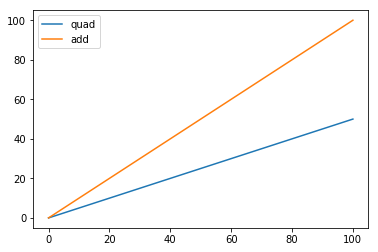

In [157]:
x = np.linspace(0,100)
quad = np.sqrt((x/4)**2+(x/4)**2+(x/4)**2+(x/4)**2)
add = x 
plt.plot(x,quad,label='quad')
plt.plot(x,add,label='add')
plt.legend()

In [172]:
from astropy.table import Table,vstack
import glob
import os

if os.getcwd()=='/Users/rs548/GitHub/lsst-ir-fusion/dmu5/dmu5_SXDS/slurm':
    BUTLER_LOC = '/Volumes/Raph500/lsst-ir-fusion/dmu4/dmu4_Example/data'
    DATA = '/Volumes/Raph500/lsst-ir-fusion/dmu5/dmu5_Example/data'
else:
    BUTLER_LOC = '../../../dmu4/dmu4_VIDEO/data'
DATA =  './data'
#butler =  dafPersist.Butler(inputs='{}/rerun/coaddForcedPhot'.format(BUTLER_LOC))

red_cats = glob.glob(DATA+'/*reducedCat.fits')

full_cat = Table()
for r in red_cats:
    try:
        t= Table.read(r)
        #mask = t['VISTA_Ks_m_detect_isPatchInner'].astype('bool') & t['VISTA_Ks_m_detect_isTractInner'].astype('bool')
        full_cat=vstack([full_cat,t])
    except:
        print(r,' failed')
full_cat.write(DATA+'/full_reduced_cat_SXDS_t.fits', overwrite=True)

In [168]:
t= Table.read('./data/8523_5,2_reducedCat.fits')
mask = t['VISTA_Ks_m_detect_isPatchInner'].astype('bool') & t['VISTA_Ks_m_detect_isTractInner'].astype('bool')

KeyError: 'VISTA_Ks_m_detect_isPatchInner'

In [169]:
t

id,VISTA_Z_m_slot_ModelFlux_magErr,VISTA_Z_m_slot_ModelFlux_mag,VISTA_Z_m_slot_ModelFlux_fluxErr,VISTA_Z_m_slot_ModelFlux_flux,VISTA_Z_m_slot_ModelFlux_flag,VISTA_Z_m_base_PsfFlux_magErr,VISTA_Z_m_base_PsfFlux_mag,VISTA_Z_m_base_PsfFlux_fluxErr,VISTA_Z_m_base_PsfFlux_flux,VISTA_Z_m_base_PsfFlux_flag,VISTA_Z_m_base_ClassificationExtendedness_value,VISTA_Z_m_base_ClassificationExtendedness_flag,VISTA_Z_m_base_CircularApertureFlux_6_0_magErr,VISTA_Z_m_base_CircularApertureFlux_6_0_mag,VISTA_Z_m_base_CircularApertureFlux_6_0_fluxErr,VISTA_Z_m_base_CircularApertureFlux_6_0_flux,VISTA_Z_m_base_CircularApertureFlux_6_0_flag,VISTA_Y_m_slot_ModelFlux_magErr,VISTA_Y_m_slot_ModelFlux_mag,VISTA_Y_m_slot_ModelFlux_fluxErr,VISTA_Y_m_slot_ModelFlux_flux,VISTA_Y_m_slot_ModelFlux_flag,VISTA_Y_m_base_PsfFlux_magErr,VISTA_Y_m_base_PsfFlux_mag,VISTA_Y_m_base_PsfFlux_fluxErr,VISTA_Y_m_base_PsfFlux_flux,VISTA_Y_m_base_PsfFlux_flag,VISTA_Y_m_base_ClassificationExtendedness_value,VISTA_Y_m_base_ClassificationExtendedness_flag,VISTA_Y_m_base_CircularApertureFlux_6_0_magErr,VISTA_Y_m_base_CircularApertureFlux_6_0_mag,VISTA_Y_m_base_CircularApertureFlux_6_0_fluxErr,VISTA_Y_m_base_CircularApertureFlux_6_0_flux,VISTA_Y_m_base_CircularApertureFlux_6_0_flag,VISTA_Ks_m_slot_ModelFlux_magErr,VISTA_Ks_m_slot_ModelFlux_mag,VISTA_Ks_m_slot_ModelFlux_fluxErr,VISTA_Ks_m_slot_ModelFlux_flux,VISTA_Ks_m_slot_ModelFlux_flag,VISTA_Ks_m_merge_peak_sky,VISTA_Ks_m_detect_isTractInner,VISTA_Ks_m_detect_isPrimary,VISTA_Ks_m_deblend_nChild,VISTA_Ks_m_coord_ra,VISTA_Ks_m_coord_dec,VISTA_Ks_m_base_PsfFlux_magErr,VISTA_Ks_m_base_PsfFlux_mag,VISTA_Ks_m_base_PsfFlux_fluxErr,VISTA_Ks_m_base_PsfFlux_flux,VISTA_Ks_m_base_PsfFlux_flag,VISTA_Ks_m_base_ClassificationExtendedness_value,VISTA_Ks_m_base_ClassificationExtendedness_flag,VISTA_Ks_m_base_CircularApertureFlux_6_0_magErr,VISTA_Ks_m_base_CircularApertureFlux_6_0_mag,VISTA_Ks_m_base_CircularApertureFlux_6_0_fluxErr,VISTA_Ks_m_base_CircularApertureFlux_6_0_flux,VISTA_Ks_m_base_CircularApertureFlux_6_0_flag,VISTA_J_m_slot_ModelFlux_magErr,VISTA_J_m_slot_ModelFlux_mag,VISTA_J_m_slot_ModelFlux_fluxErr,VISTA_J_m_slot_ModelFlux_flux,VISTA_J_m_slot_ModelFlux_flag,VISTA_J_m_base_PsfFlux_magErr,VISTA_J_m_base_PsfFlux_mag,VISTA_J_m_base_PsfFlux_fluxErr,VISTA_J_m_base_PsfFlux_flux,VISTA_J_m_base_PsfFlux_flag,VISTA_J_m_base_ClassificationExtendedness_value,VISTA_J_m_base_ClassificationExtendedness_flag,VISTA_J_m_base_CircularApertureFlux_6_0_magErr,VISTA_J_m_base_CircularApertureFlux_6_0_mag,VISTA_J_m_base_CircularApertureFlux_6_0_fluxErr,VISTA_J_m_base_CircularApertureFlux_6_0_flux,VISTA_J_m_base_CircularApertureFlux_6_0_flag,VISTA_H_m_slot_ModelFlux_magErr,VISTA_H_m_slot_ModelFlux_mag,VISTA_H_m_slot_ModelFlux_fluxErr,VISTA_H_m_slot_ModelFlux_flux,VISTA_H_m_slot_ModelFlux_flag,VISTA_H_m_base_PsfFlux_magErr,VISTA_H_m_base_PsfFlux_mag,VISTA_H_m_base_PsfFlux_fluxErr,VISTA_H_m_base_PsfFlux_flux,VISTA_H_m_base_PsfFlux_flag,VISTA_H_m_base_ClassificationExtendedness_value,VISTA_H_m_base_ClassificationExtendedness_flag,VISTA_H_m_base_CircularApertureFlux_6_0_magErr,VISTA_H_m_base_CircularApertureFlux_6_0_mag,VISTA_H_m_base_CircularApertureFlux_6_0_fluxErr,VISTA_H_m_base_CircularApertureFlux_6_0_flux,VISTA_H_m_base_CircularApertureFlux_6_0_flag,HSC_Z_m_slot_ModelFlux_magErr,HSC_Z_m_slot_ModelFlux_mag,HSC_Z_m_slot_ModelFlux_fluxErr,HSC_Z_m_slot_ModelFlux_flux,HSC_Z_m_slot_ModelFlux_flag,HSC_Z_m_base_PsfFlux_magErr,HSC_Z_m_base_PsfFlux_mag,HSC_Z_m_base_PsfFlux_fluxErr,HSC_Z_m_base_PsfFlux_flux,HSC_Z_m_base_PsfFlux_flag,HSC_Z_m_base_ClassificationExtendedness_value,HSC_Z_m_base_ClassificationExtendedness_flag,HSC_Z_m_base_CircularApertureFlux_6_0_magErr,HSC_Z_m_base_CircularApertureFlux_6_0_mag,HSC_Z_m_base_CircularApertureFlux_6_0_fluxErr,HSC_Z_m_base_CircularApertureFlux_6_0_flux,HSC_Z_m_base_CircularApertureFlux_6_0_flag,HSC_Y_m_slot_ModelFlux_magErr,HSC_Y_m_slot_ModelFlux_mag,HSC_Y_m_slot_ModelFlux_fluxErr,HSC_Y_m_slot_ModelFlux_flux,HSC_Y_m_slot_M

In [120]:
measSources = butler.get('deepCoadd_meas', {'filter': 'VISTA-Ks', 'tract': 8524, 'patch': '3,5'})

In [121]:
measSources.schema.find('base_ClassificationExtendedness_value').field.getDoc()

'Set to 1 for extended sources, 0 for point sources.'

In [122]:
measSources['base_ClassificationExtendedness_value']

array([nan, nan, nan, ...,  0., nan, nan])

In [132]:
t=Table.read('./data/full_reduced_cat_SXDS.fits')[:100000]

In [144]:
for c in t.colnames:
    if t[c].dtype=='>f8':
        m=t[c]>1.e19
        t[c][m]=np.nan

In [145]:
t

id,VISTA_Z_m_slot_ModelFlux_magErr,VISTA_Z_m_slot_ModelFlux_mag,VISTA_Z_m_slot_ModelFlux_fluxErr,VISTA_Z_m_slot_ModelFlux_flux,VISTA_Z_m_slot_ModelFlux_flag,VISTA_Z_m_base_PsfFlux_magErr,VISTA_Z_m_base_PsfFlux_mag,VISTA_Z_m_base_PsfFlux_fluxErr,VISTA_Z_m_base_PsfFlux_flux,VISTA_Z_m_base_PsfFlux_flag,VISTA_Z_m_base_CircularApertureFlux_6_0_magErr,VISTA_Z_m_base_CircularApertureFlux_6_0_mag,VISTA_Z_m_base_CircularApertureFlux_6_0_fluxErr,VISTA_Z_m_base_CircularApertureFlux_6_0_flux,VISTA_Z_m_base_CircularApertureFlux_6_0_flag,VISTA_Y_m_slot_ModelFlux_magErr,VISTA_Y_m_slot_ModelFlux_mag,VISTA_Y_m_slot_ModelFlux_fluxErr,VISTA_Y_m_slot_ModelFlux_flux,VISTA_Y_m_slot_ModelFlux_flag,VISTA_Y_m_base_PsfFlux_magErr,VISTA_Y_m_base_PsfFlux_mag,VISTA_Y_m_base_PsfFlux_fluxErr,VISTA_Y_m_base_PsfFlux_flux,VISTA_Y_m_base_PsfFlux_flag,VISTA_Y_m_base_CircularApertureFlux_6_0_magErr,VISTA_Y_m_base_CircularApertureFlux_6_0_mag,VISTA_Y_m_base_CircularApertureFlux_6_0_fluxErr,VISTA_Y_m_base_CircularApertureFlux_6_0_flux,VISTA_Y_m_base_CircularApertureFlux_6_0_flag,VISTA_Ks_m_slot_ModelFlux_magErr,VISTA_Ks_m_slot_ModelFlux_mag,VISTA_Ks_m_slot_ModelFlux_fluxErr,VISTA_Ks_m_slot_ModelFlux_flux,VISTA_Ks_m_slot_ModelFlux_flag,VISTA_Ks_m_merge_peak_sky,VISTA_Ks_m_detect_isTractInner,VISTA_Ks_m_detect_isPrimary,VISTA_Ks_m_detect_isPatchInner,VISTA_Ks_m_deblend_nChild,VISTA_Ks_m_coord_ra,VISTA_Ks_m_coord_dec,VISTA_Ks_m_base_PsfFlux_magErr,VISTA_Ks_m_base_PsfFlux_mag,VISTA_Ks_m_base_PsfFlux_fluxErr,VISTA_Ks_m_base_PsfFlux_flux,VISTA_Ks_m_base_PsfFlux_flag,VISTA_Ks_m_base_ClassificationExtendedness_value,VISTA_Ks_m_base_ClassificationExtendedness_flag,VISTA_Ks_m_base_CircularApertureFlux_6_0_magErr,VISTA_Ks_m_base_CircularApertureFlux_6_0_mag,VISTA_Ks_m_base_CircularApertureFlux_6_0_fluxErr,VISTA_Ks_m_base_CircularApertureFlux_6_0_flux,VISTA_Ks_m_base_CircularApertureFlux_6_0_flag,VISTA_J_m_slot_ModelFlux_magErr,VISTA_J_m_slot_ModelFlux_mag,VISTA_J_m_slot_ModelFlux_fluxErr,VISTA_J_m_slot_ModelFlux_flux,VISTA_J_m_slot_ModelFlux_flag,VISTA_J_m_base_PsfFlux_magErr,VISTA_J_m_base_PsfFlux_mag,VISTA_J_m_base_PsfFlux_fluxErr,VISTA_J_m_base_PsfFlux_flux,VISTA_J_m_base_PsfFlux_flag,VISTA_J_m_base_CircularApertureFlux_6_0_magErr,VISTA_J_m_base_CircularApertureFlux_6_0_mag,VISTA_J_m_base_CircularApertureFlux_6_0_fluxErr,VISTA_J_m_base_CircularApertureFlux_6_0_flux,VISTA_J_m_base_CircularApertureFlux_6_0_flag,VISTA_H_m_slot_ModelFlux_magErr,VISTA_H_m_slot_ModelFlux_mag,VISTA_H_m_slot_ModelFlux_fluxErr,VISTA_H_m_slot_ModelFlux_flux,VISTA_H_m_slot_ModelFlux_flag,VISTA_H_m_base_PsfFlux_magErr,VISTA_H_m_base_PsfFlux_mag,VISTA_H_m_base_PsfFlux_fluxErr,VISTA_H_m_base_PsfFlux_flux,VISTA_H_m_base_PsfFlux_flag,VISTA_H_m_base_CircularApertureFlux_6_0_magErr,VISTA_H_m_base_CircularApertureFlux_6_0_mag,VISTA_H_m_base_CircularApertureFlux_6_0_fluxErr,VISTA_H_m_base_CircularApertureFlux_6_0_flux,VISTA_H_m_base_CircularApertureFlux_6_0_flag,HSC_Z_m_slot_ModelFlux_magErr,HSC_Z_m_slot_ModelFlux_mag,HSC_Z_m_slot_ModelFlux_fluxErr,HSC_Z_m_slot_ModelFlux_flux,HSC_Z_m_slot_ModelFlux_flag,HSC_Z_m_base_PsfFlux_magErr,HSC_Z_m_base_PsfFlux_mag,HSC_Z_m_base_PsfFlux_fluxErr,HSC_Z_m_base_PsfFlux_flux,HSC_Z_m_base_PsfFlux_flag,HSC_Z_m_base_CircularApertureFlux_6_0_magErr,HSC_Z_m_base_CircularApertureFlux_6_0_mag,HSC_Z_m_base_CircularApertureFlux_6_0_fluxErr,HSC_Z_m_base_CircularApertureFlux_6_0_flux,HSC_Z_m_base_CircularApertureFlux_6_0_flag,HSC_Y_m_slot_ModelFlux_magErr,HSC_Y_m_slot_ModelFlux_mag,HSC_Y_m_slot_ModelFlux_fluxErr,HSC_Y_m_slot_ModelFlux_flux,HSC_Y_m_slot_ModelFlux_flag,HSC_Y_m_base_PsfFlux_magErr,HSC_Y_m_base_PsfFlux_mag,HSC_Y_m_base_PsfFlux_fluxErr,HSC_Y_m_base_PsfFlux_flux,HSC_Y_m_base_PsfFlux_flag,HSC_Y_m_base_CircularApertureFlux_6_0_magErr,HSC_Y_m_base_CircularApertureFlux_6_0_mag,HSC_Y_m_base_CircularApertureFlux_6_0_fluxErr,HSC_Y_m_base_CircularApertureFlux_6_0_flux,HSC_Y_m_base_CircularApertureFlux_6_0_flag,HSC_R_m_slot_ModelFlux_magErr,HSC_R_m_slot_ModelFlux_mag,HSC_R_m_slot_Mod

In [129]:
m=measSources.asAstropy()
#m['base_ClassificationExtendedness_value']=measSources['base_ClassificationExtendedness_value']
m[:5]

id,coord_ra,coord_dec,parent,merge_footprint_HSC-I,merge_footprint_HSC-R,merge_footprint_HSC-Z,merge_footprint_HSC-Y,merge_footprint_HSC-G,merge_footprint_VISTA-Z,merge_footprint_VISTA-Y,merge_footprint_VISTA-J,merge_footprint_VISTA-H,merge_footprint_VISTA-Ks,merge_footprint_sky,merge_peak_HSC-I,merge_peak_HSC-R,merge_peak_HSC-Z,merge_peak_HSC-Y,merge_peak_HSC-G,merge_peak_VISTA-Z,merge_peak_VISTA-Y,merge_peak_VISTA-J,merge_peak_VISTA-H,merge_peak_VISTA-Ks,merge_peak_sky,deblend_nChild,deblend_deblendedAsPsf,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psf_instFlux,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_skipped,deblend_rampedTemplate,deblend_patchedTemplate,deblend_hasStrayFlux,deblend_peak_center_x,deblend_peak_center_y,deblend_peakId,deblend_nPeaks,deblend_parentNPeaks,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_InputCount_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,ext_convolved_ConvolvedFlux_0_flag_badCentroid,ext_convolved_ConvolvedFlux_1_flag_badCentroid,ext_convolved_ConvolvedFlux_2_flag_badCentroid,ext_convolved_ConvolvedFlux_flag_badCentroid,ext_photometryKron_KronFlux_flag_badInitialCentroid,ext_shapeHSM_HsmPsfMoments_flag_badCentroid,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid,ext_shapeHSM_HsmSourceMoments_flag_badCentroid,modelfit_DoubleShapeletPsfApprox_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_InputCount_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,ext_convolved_ConvolvedFlux_0_flag_badCentroid_edge,ext_convolved_ConvolvedFlux_1_flag_badCentroid_edge,ext_convolved_ConvolvedFlux_2_flag_badCentroid_edge,ext_convolved_ConvolvedFlux_flag_badCentroid_edge,ext_photometryKron_KronFlux_flag_badInitialCentroid_edge,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_edge,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_edge,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_edge,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_edge,modelfit_DoubleShapeletPsfApprox_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_InputCount_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,ext_convolved_ConvolvedFlux_0_flag_badCentroid_noSecondDerivative,ext_convolved_ConvolvedFlux_1_flag_badCentroid_noSecondDerivative,ext_convolved_ConvolvedFlux_2_flag_badCentroid_noSecondDerivative,ext_convolved_ConvolvedFlux_flag_badCentroid_noSecondDerivative,ext_photometryKron_KronFlux_flag_badInitialCentroid_noSecondDerivative,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_noSecondDerivative,modelfit_DoubleShapeletPsfApprox_flag_badCentroid_noSecondDerivative,slot_Centroid_f

In [130]:
for c in m.colnames:
    if 'Extend' in c:
        print(c)

base_ClassificationExtendedness_value
base_ClassificationExtendedness_flag


In [131]:
"{}_test".format('first','second')

'first_test'

In [14]:
cat.colnames[0:5]

['id',
 'HSC-G_m_coord_ra',
 'HSC-G_m_coord_dec',
 'HSC-G_m_parent',
 'HSC-G_m_merge_footprint_HSC-G']

In [15]:
cat['HSC-G_m_slot_CalibFlux_instFlux'].description.replace('instFlux', 'mag')

'mag within 12.000000-pixel aperture'

In [16]:
cat['HSC-G_m_slot_CalibFlux_mag'].description

'mag within 12.000000-pixel aperture'

In [17]:
cols = Table()
cols['name'] = cat.colnames
cols['description'] = [cat[c].description for c in cat.colnames]
cols['unit'] = [str(cat[c].unit) for c in cat.colnames]
cols['type'] = [cat[c].dtype for c in cat.colnames]
cols.write('./columns_descriptions.csv')

In [35]:
reduced_cols = [ 
    'id', 
    'VISTA-Ks_m_coord_ra', 
    'VISTA-Ks_m_coord_dec',
    'VISTA-Ks_m_detect_isPatchInner',
    'VISTA-Ks_m_detect_isTractInner'
]
for aper in ['6', '9', '12', '17']:
    reduced_cols += ['{}_m_base_CircularApertureFlux_{}_0_mag'.format(b,aper) for b in allBands]
    reduced_cols += ['{}_m_base_CircularApertureFlux_{}_0_magErr'.format(b,aper) for b in allBands]
    reduced_cols += ['{}_m_base_CircularApertureFlux_{}_0_flag'.format(b,aper) for b in allBands]
    
reduced_cols += ['{}_m_base_PsfFlux_apCorr'.format(b) for b in allBands]
reduced_cols

['id',
 'VISTA-Ks_m_coord_ra',
 'VISTA-Ks_m_coord_dec',
 'VISTA-Ks_m_detect_isPatchInner',
 'VISTA-Ks_m_detect_isTractInner',
 'HSC-G_m_base_CircularApertureFlux_6_0_mag',
 'HSC-R_m_base_CircularApertureFlux_6_0_mag',
 'HSC-I_m_base_CircularApertureFlux_6_0_mag',
 'HSC-Z_m_base_CircularApertureFlux_6_0_mag',
 'HSC-Y_m_base_CircularApertureFlux_6_0_mag',
 'VISTA-Z_m_base_CircularApertureFlux_6_0_mag',
 'VISTA-Y_m_base_CircularApertureFlux_6_0_mag',
 'VISTA-J_m_base_CircularApertureFlux_6_0_mag',
 'VISTA-H_m_base_CircularApertureFlux_6_0_mag',
 'VISTA-Ks_m_base_CircularApertureFlux_6_0_mag',
 'HSC-G_m_base_CircularApertureFlux_6_0_magErr',
 'HSC-R_m_base_CircularApertureFlux_6_0_magErr',
 'HSC-I_m_base_CircularApertureFlux_6_0_magErr',
 'HSC-Z_m_base_CircularApertureFlux_6_0_magErr',
 'HSC-Y_m_base_CircularApertureFlux_6_0_magErr',
 'VISTA-Z_m_base_CircularApertureFlux_6_0_magErr',
 'VISTA-Y_m_base_CircularApertureFlux_6_0_magErr',
 'VISTA-J_m_base_CircularApertureFlux_6_0_magErr',
 'VIS

## Run over all patches
Now we simply loop over every patch to make the full field. This will only work on a small number of patches. The functions developed here will be added to obs_vista in due course for creating job arrays.

In [19]:
set(reduced_cols).intersection(set(cat.colnames))

{'HSC-G_m_base_CircularApertureFlux_12_0_flag',
 'HSC-G_m_base_CircularApertureFlux_12_0_mag',
 'HSC-G_m_base_CircularApertureFlux_12_0_magErr',
 'HSC-G_m_base_CircularApertureFlux_17_0_flag',
 'HSC-G_m_base_CircularApertureFlux_17_0_mag',
 'HSC-G_m_base_CircularApertureFlux_17_0_magErr',
 'HSC-G_m_base_CircularApertureFlux_6_0_flag',
 'HSC-G_m_base_CircularApertureFlux_6_0_mag',
 'HSC-G_m_base_CircularApertureFlux_6_0_magErr',
 'HSC-G_m_base_CircularApertureFlux_9_0_flag',
 'HSC-G_m_base_CircularApertureFlux_9_0_mag',
 'HSC-G_m_base_CircularApertureFlux_9_0_magErr',
 'HSC-G_m_base_PsfFlux_apCorr',
 'HSC-I_m_base_CircularApertureFlux_12_0_flag',
 'HSC-I_m_base_CircularApertureFlux_12_0_mag',
 'HSC-I_m_base_CircularApertureFlux_12_0_magErr',
 'HSC-I_m_base_CircularApertureFlux_17_0_flag',
 'HSC-I_m_base_CircularApertureFlux_17_0_mag',
 'HSC-I_m_base_CircularApertureFlux_17_0_magErr',
 'HSC-I_m_base_CircularApertureFlux_6_0_flag',
 'HSC-I_m_base_CircularApertureFlux_6_0_mag',
 'HSC-I_m_b

In [20]:
reduced_cat = Table()
mask = cat['VISTA-Ks_m_detect_isPatchInner'] & cat['VISTA-Ks_m_detect_isTractInner']
reduced_cat = vstack([reduced_cat, cat[mask][list(set(reduced_cols).intersection(set(cat.colnames)) )]])

In [21]:
reduced_cat[:5]

VISTA-J_m_base_CircularApertureFlux_17_0_flag,HSC-G_m_base_CircularApertureFlux_6_0_magErr,VISTA-J_m_base_CircularApertureFlux_9_0_magErr,VISTA-J_m_base_CircularApertureFlux_6_0_mag,HSC-G_m_base_CircularApertureFlux_9_0_mag,VISTA-J_m_base_CircularApertureFlux_6_0_magErr,HSC-Y_m_base_CircularApertureFlux_12_0_magErr,VISTA-Y_m_base_CircularApertureFlux_9_0_magErr,HSC-G_m_base_CircularApertureFlux_9_0_flag,HSC-Y_m_base_CircularApertureFlux_9_0_mag,VISTA-Y_m_base_PsfFlux_apCorr,HSC-Z_m_base_CircularApertureFlux_12_0_flag,VISTA-J_m_base_CircularApertureFlux_12_0_flag,VISTA-Ks_m_base_CircularApertureFlux_9_0_magErr,HSC-Z_m_base_CircularApertureFlux_9_0_flag,HSC-I_m_base_CircularApertureFlux_12_0_flag,VISTA-H_m_base_CircularApertureFlux_6_0_flag,HSC-G_m_base_CircularApertureFlux_17_0_magErr,HSC-R_m_base_CircularApertureFlux_6_0_flag,HSC-Y_m_base_PsfFlux_apCorr,VISTA-Ks_m_base_CircularApertureFlux_17_0_flag,VISTA-Ks_m_base_CircularApertureFlux_17_0_magErr,HSC-I_m_base_PsfFlux_apCorr,VISTA-J_m_base_CircularApertureFlux_12_0_magErr,HSC-R_m_base_CircularApertureFlux_6_0_magErr,HSC-Z_m_base_CircularApertureFlux_17_0_flag,HSC-Z_m_base_CircularApertureFlux_17_0_magErr,HSC-R_m_base_CircularApertureFlux_17_0_mag,HSC-Y_m_base_CircularApertureFlux_12_0_mag,VISTA-Y_m_base_CircularApertureFlux_6_0_magErr,HSC-I_m_base_CircularApertureFlux_12_0_mag,HSC-Z_m_base_CircularApertureFlux_9_0_mag,VISTA-Ks_m_base_CircularApertureFlux_12_0_flag,HSC-R_m_base_PsfFlux_apCorr,VISTA-H_m_base_CircularApertureFlux_17_0_flag,VISTA-Y_m_base_CircularApertureFlux_17_0_flag,HSC-G_m_base_CircularApertureFlux_6_0_mag,HSC-R_m_base_CircularApertureFlux_9_0_magErr,HSC-I_m_base_CircularApertureFlux_17_0_flag,VISTA-Ks_m_base_CircularApertureFlux_6_0_magErr,HSC-G_m_base_CircularApertureFlux_9_0_magErr,VISTA-Ks_m_base_CircularApertureFlux_9_0_flag,HSC-Z_m_base_CircularApertureFlux_12_0_magErr,HSC-I_m_base_CircularApertureFlux_17_0_mag,VISTA-Ks_m_base_CircularApertureFlux_9_0_mag,HSC-I_m_base_CircularApertureFlux_6_0_mag,VISTA-Ks_m_base_PsfFlux_apCorr,HSC-R_m_base_CircularApertureFlux_9_0_mag,HSC-Y_m_base_CircularApertureFlux_6_0_flag,VISTA-Ks_m_coord_ra,HSC-I_m_base_CircularApertureFlux_9_0_mag,HSC-G_m_base_PsfFlux_apCorr,HSC-Y_m_base_CircularApertureFlux_9_0_magErr,HSC-R_m_base_CircularApertureFlux_12_0_mag,HSC-R_m_base_CircularApertureFlux_12_0_magErr,VISTA-J_m_base_CircularApertureFlux_12_0_mag,HSC-R_m_base_CircularApertureFlux_6_0_mag,HSC-G_m_base_CircularApertureFlux_12_0_magErr,HSC-G_m_base_CircularApertureFlux_6_0_flag,HSC-R_m_base_CircularApertureFlux_9_0_flag,HSC-R_m_base_CircularApertureFlux_12_0_flag,HSC-R_m_base_CircularApertureFlux_17_0_magErr,VISTA-J_m_base_CircularApertureFlux_6_0_flag,VISTA-Y_m_base_CircularApertureFlux_9_0_mag,VISTA-J_m_base_CircularApertureFlux_9_0_flag,VISTA-Ks_m_base_CircularApertureFlux_12_0_magErr,VISTA-Ks_m_base_CircularApertureFlux_6_0_flag,HSC-Y_m_base_CircularApertureFlux_6_0_magErr,HSC-Z_m_base_CircularApertureFlux_6_0_magErr,HSC-I_m_base_CircularApertureFlux_17_0_magErr,VISTA-H_m_base_CircularApertureFlux_6_0_magErr,VISTA-H_m_base_CircularApertureFlux_9_0_mag,HSC-Z_m_base_CircularApertureFlux_12_0_mag,VISTA-Y_m_base_CircularApertureFlux_17_0_mag,HSC-Z_m_base_CircularApertureFlux_17_0_mag,HSC-I_m_base_CircularApertureFlux_12_0_magErr,HSC-G_m_base_CircularApertureFlux_12_0_mag,VISTA-Y_m_base_CircularApertureFlux_12_0_flag,HSC-Z_m_base_CircularApertureFlux_9_0_magErr,VISTA-Y_m_base_CircularApertureFlux_9_0_flag,HSC-Y_m_base_CircularApertureFlux_17_0_magErr,VISTA-H_m_base_CircularApertureFlux_9_0_magErr,HSC-I_m_base_CircularApertureFlux_6_0_magErr,VISTA-J_m_base_CircularApertureFlux_9_0_mag,HSC-Y_m_base_CircularApertureFlux_17_0_mag,VISTA-Y_m_base_CircularApertureFlux_12_0_magErr,VISTA-Y_m_base_CircularApertureFlux_6_0_flag,HSC-G_m_base_CircularApertureFlux_12_0_flag,VISTA-J_m_base_CircularApertureFlux_17_0_mag,HSC-Y_m_base_CircularApertureFlux_12_0_flag,VISTA-Ks_m_base_CircularApertureFlux_12_0_mag,HSC-Z_m_base_CircularApertureFlux_6_0_

In [36]:
name_base = DATA+'/full_cat_{}_{}_tab{}.fits'
reduced_cat = Table()
p_n=0
for tract in full_patch_dict:
    for patch in full_patch_dict[tract]:
        #print(type(tract), type(patch))
        #skip if file exists
        if os.path.exists(DATA+'/reduced_cat_{}_{}.fits'.format(tract,patch)):
            print('Tract {}, patch {} already done'.format(tract, patch))
            #continue
        try:
            cat = makeCat(tract, patch, BUTLER_LOC)
            #These commented lines will print the catalogue in 1000 column chunks keeping id
            #bounds = np.append(np.arange(0,len(cat.colnames),998),len(cat.colnames))
            #for n in np.arange(len(bounds)-1):
            #    #Write tables in 1000 columns blocks
            #    #print(bounds[n], bounds[n+1])
            #    sub_cols=list(set(cat.colnames[bounds[n]:bounds[n+1]]).intersection(set(['id'])) )
            #    cat[cat.colnames[bounds[n]:bounds[n+1]]].write(name_base.format(
            #        tract,patch,n
            #    ), overwrite=True)
              
                
            #mask = cat['VISTA-Ks_m_detect_isPatchInner'] & cat['VISTA-Ks_m_detect_isTractInner']
            #cat = cat[mask]
            #get the set of reduced column names that are available (maybe not all bands)
            intersect_red_cols =list(set(reduced_cols).intersection(set(cat.colnames)) )
            cat = cat[sorted(intersect_red_cols, reverse=True)]
            #We need to remove the meta data to allow the reduced cat to be opened by astropy fits
            #TODO write a function to clear only the removed columns or remove each col independently.
            cat.meta = None
            cat.write(
                DATA+'/reduced_cat_{}_{}.fits'.format(tract,patch), overwrite=True
            )
       
            p_n+=1
            #Try to fix memory issues:
            del cat
            gc.collect()
            time.sleep(1)
        except:
            print('Tract {}, patch {} failed'.format(tract, patch))
            pass #
        

Tract 8282, patch 0,8 failed
Tract 8283, patch 0,8 failed
Tract 8283, patch 1,7 failed
Tract 8283, patch 1,8 failed
Tract 8283, patch 2,7 failed
Tract 8283, patch 2,8 failed
Tract 8283, patch 3,7 failed
Tract 8283, patch 3,8 failed
Tract 8283, patch 4,7 failed
Tract 8283, patch 4,8 failed
Tract 8283, patch 5,7 failed
Tract 8283, patch 5,8 failed
Tract 8283, patch 6,7 failed
Tract 8283, patch 6,8 failed
Tract 8283, patch 7,7 failed
Tract 8283, patch 7,8 failed
Tract 8283, patch 8,8 failed
Tract 8284, patch 8,8 failed
Tract 8523, patch 0,1 failed
Tract 8523, patch 0,2 failed
Tract 8523, patch 0,3 failed
Tract 8523, patch 0,4 failed
Tract 8523, patch 0,5 failed
Tract 8523, patch 0,6 failed
Tract 8523, patch 0,7 failed
Tract 8523, patch 0,8 failed
Tract 8523, patch 1,1 failed
Tract 8523, patch 1,2 failed
Tract 8523, patch 1,3 failed
Tract 8523, patch 1,4 failed
Tract 8523, patch 1,5 failed
Tract 8523, patch 1,6 failed
Tract 8523, patch 1,7 failed
Tract 8523, patch 1,8 failed
Tract 8523, pa

In [23]:
p_n

9

In [22]:
tract,patch = 8524,'3,3'
cat = makeCat(tract,patch, BUTLER_LOC)
intersect_red_cols =list(set(reduced_cols).intersection(set(cat.colnames)) )
cat = cat[sorted(intersect_red_cols, reverse=True)]
cat.meta = None
cat.write(
    DATA+'/reduced_cat_{}_{}.fits'.format(tract,patch), overwrite=True
)

DEBUG:  /Volumes/Raph500/lsst-ir-fusion/dmu4/dmu4_Example/data/rerun/coaddPhot/deepCoadd-results/HSC-G/8524/3,3/meas-HSC-G-8524-3,3.fits
DEBUG:  /Volumes/Raph500/lsst-ir-fusion/dmu4/dmu4_Example/data/rerun/coaddForcedPhot/deepCoadd-results/HSC-G/8524/3,3/forcedSrc-HSC-G-8524-3,3.fits
DEBUG:  /Volumes/Raph500/lsst-ir-fusion/dmu4/dmu4_Example/data/rerun/coaddPhot/deepCoadd-results/HSC-R/8524/3,3/meas-HSC-R-8524-3,3.fits
DEBUG:  /Volumes/Raph500/lsst-ir-fusion/dmu4/dmu4_Example/data/rerun/coaddForcedPhot/deepCoadd-results/HSC-R/8524/3,3/forcedSrc-HSC-R-8524-3,3.fits
DEBUG:  /Volumes/Raph500/lsst-ir-fusion/dmu4/dmu4_Example/data/rerun/coaddPhot/deepCoadd-results/HSC-I/8524/3,3/meas-HSC-I-8524-3,3.fits
DEBUG:  /Volumes/Raph500/lsst-ir-fusion/dmu4/dmu4_Example/data/rerun/coaddForcedPhot/deepCoadd-results/HSC-I/8524/3,3/forcedSrc-HSC-I-8524-3,3.fits
DEBUG:  /Volumes/Raph500/lsst-ir-fusion/dmu4/dmu4_Example/data/rerun/coaddPhot/deepCoadd-results/HSC-Z/8524/3,3/meas-HSC-Z-8524-3,3.fits
DEBUG:  

In [23]:
test = Table.read(DATA+'/reduced_cat_{}_{}.fits'.format(tract,patch))

In [24]:
test['id'].description

'unique ID'

In [26]:
test['VISTA-Ks_m_base_CircularApertureFlux_6_0_mag'].unit

Unit("mag")

In [30]:
#len(reduced_cat)

In [31]:
#reduced_cat[:5]

In [32]:
#reduced_cat.write(DATA+'/reduced_cat.fits', overwrite=True)

## Parellel code

Here we will make a single cell to be written to a script for parrellelising. The following cell depends on all the imports and defs used in the notebook. See [./slurm/make_cat.py](./slurm/make_cat.py) for the final code

In [50]:
job_id = 34

job_dict=json.loads(open('../../dmu4/dmu4_SXDS/slurm/patch_job_dict.json', 'r').read())

tract = job_dict[str(job_id)][0]
patch = job_dict[str(job_id)][1]

cat = makeCat(tract, patch, BUTLER_LOC)

intersect_red_cols =list(set(reduced_cols).intersection(set(cat.colnames)) )
        
cat[sorted(intersect_red_cols, reverse=True)].write(
    DATA+'/reduced_cat_{}_{}.fits'.format(tract,patch), overwrite=True
)



DEBUG:  /Volumes/Raph500/lsst-ir-fusion/dmu4/dmu4_Example/data/rerun/coaddPhot/deepCoadd-results/HSC-G/8524/3,3/meas-HSC-G-8524-3,3.fits
DEBUG:  /Volumes/Raph500/lsst-ir-fusion/dmu4/dmu4_Example/data/rerun/coaddForcedPhot/deepCoadd-results/HSC-G/8524/3,3/forcedSrc-HSC-G-8524-3,3.fits
DEBUG:  /Volumes/Raph500/lsst-ir-fusion/dmu4/dmu4_Example/data/rerun/coaddPhot/deepCoadd-results/HSC-R/8524/3,3/meas-HSC-R-8524-3,3.fits
DEBUG:  /Volumes/Raph500/lsst-ir-fusion/dmu4/dmu4_Example/data/rerun/coaddForcedPhot/deepCoadd-results/HSC-R/8524/3,3/forcedSrc-HSC-R-8524-3,3.fits
DEBUG:  /Volumes/Raph500/lsst-ir-fusion/dmu4/dmu4_Example/data/rerun/coaddPhot/deepCoadd-results/HSC-I/8524/3,3/meas-HSC-I-8524-3,3.fits
DEBUG:  /Volumes/Raph500/lsst-ir-fusion/dmu4/dmu4_Example/data/rerun/coaddForcedPhot/deepCoadd-results/HSC-I/8524/3,3/forcedSrc-HSC-I-8524-3,3.fits
DEBUG:  /Volumes/Raph500/lsst-ir-fusion/dmu4/dmu4_Example/data/rerun/coaddPhot/deepCoadd-results/HSC-Z/8524/3,3/meas-HSC-Z-8524-3,3.fits
DEBUG:  

## Create full cat

We then need to loop over all the reduced catalogues to build the final full catalogue.

In [28]:
import glob
red_cats = glob.glob(DATA+'/reduced*.fits')

In [29]:
red_cats

['/Volumes/Raph500/lsst-ir-fusion/dmu5/dmu5_Example/data/reduced_cat_8524_3,3.fits',
 '/Volumes/Raph500/lsst-ir-fusion/dmu5/dmu5_Example/data/reduced_cat_8524_3,4.fits',
 '/Volumes/Raph500/lsst-ir-fusion/dmu5/dmu5_Example/data/reduced_cat_8524_3,5.fits',
 '/Volumes/Raph500/lsst-ir-fusion/dmu5/dmu5_Example/data/reduced_cat_8524_4,3.fits',
 '/Volumes/Raph500/lsst-ir-fusion/dmu5/dmu5_Example/data/reduced_cat_8524_4,4.fits',
 '/Volumes/Raph500/lsst-ir-fusion/dmu5/dmu5_Example/data/reduced_cat_8524_4,5.fits',
 '/Volumes/Raph500/lsst-ir-fusion/dmu5/dmu5_Example/data/reduced_cat_8524_5,3.fits',
 '/Volumes/Raph500/lsst-ir-fusion/dmu5/dmu5_Example/data/reduced_cat_8524_5,4.fits',
 '/Volumes/Raph500/lsst-ir-fusion/dmu5/dmu5_Example/data/reduced_cat_8524_5,5.fits']

In [37]:
r = red_cats[0]
t= Table.read(r)
mask = t['VISTA-Ks_m_detect_isPatchInner'] & t['VISTA-Ks_m_detect_isTractInner']

In [34]:
t

id,VISTA-Y_m_base_PsfFlux_apCorr,VISTA-Y_m_base_CircularApertureFlux_9_0_magErr,VISTA-Y_m_base_CircularApertureFlux_9_0_mag,VISTA-Y_m_base_CircularApertureFlux_9_0_flag,VISTA-Y_m_base_CircularApertureFlux_6_0_magErr,VISTA-Y_m_base_CircularApertureFlux_6_0_mag,VISTA-Y_m_base_CircularApertureFlux_6_0_flag,VISTA-Y_m_base_CircularApertureFlux_17_0_magErr,VISTA-Y_m_base_CircularApertureFlux_17_0_mag,VISTA-Y_m_base_CircularApertureFlux_17_0_flag,VISTA-Y_m_base_CircularApertureFlux_12_0_magErr,VISTA-Y_m_base_CircularApertureFlux_12_0_mag,VISTA-Y_m_base_CircularApertureFlux_12_0_flag,VISTA-Ks_m_coord_ra,VISTA-Ks_m_coord_dec,VISTA-Ks_m_base_PsfFlux_apCorr,VISTA-Ks_m_base_CircularApertureFlux_9_0_magErr,VISTA-Ks_m_base_CircularApertureFlux_9_0_mag,VISTA-Ks_m_base_CircularApertureFlux_9_0_flag,VISTA-Ks_m_base_CircularApertureFlux_6_0_magErr,VISTA-Ks_m_base_CircularApertureFlux_6_0_mag,VISTA-Ks_m_base_CircularApertureFlux_6_0_flag,VISTA-Ks_m_base_CircularApertureFlux_17_0_magErr,VISTA-Ks_m_base_CircularApertureFlux_17_0_mag,VISTA-Ks_m_base_CircularApertureFlux_17_0_flag,VISTA-Ks_m_base_CircularApertureFlux_12_0_magErr,VISTA-Ks_m_base_CircularApertureFlux_12_0_mag,VISTA-Ks_m_base_CircularApertureFlux_12_0_flag,VISTA-J_m_base_PsfFlux_apCorr,VISTA-J_m_base_CircularApertureFlux_9_0_magErr,VISTA-J_m_base_CircularApertureFlux_9_0_mag,VISTA-J_m_base_CircularApertureFlux_9_0_flag,VISTA-J_m_base_CircularApertureFlux_6_0_magErr,VISTA-J_m_base_CircularApertureFlux_6_0_mag,VISTA-J_m_base_CircularApertureFlux_6_0_flag,VISTA-J_m_base_CircularApertureFlux_17_0_magErr,VISTA-J_m_base_CircularApertureFlux_17_0_mag,VISTA-J_m_base_CircularApertureFlux_17_0_flag,VISTA-J_m_base_CircularApertureFlux_12_0_magErr,VISTA-J_m_base_CircularApertureFlux_12_0_mag,VISTA-J_m_base_CircularApertureFlux_12_0_flag,VISTA-H_m_base_PsfFlux_apCorr,VISTA-H_m_base_CircularApertureFlux_9_0_magErr,VISTA-H_m_base_CircularApertureFlux_9_0_mag,VISTA-H_m_base_CircularApertureFlux_9_0_flag,VISTA-H_m_base_CircularApertureFlux_6_0_magErr,VISTA-H_m_base_CircularApertureFlux_6_0_mag,VISTA-H_m_base_CircularApertureFlux_6_0_flag,VISTA-H_m_base_CircularApertureFlux_17_0_magErr,VISTA-H_m_base_CircularApertureFlux_17_0_mag,VISTA-H_m_base_CircularApertureFlux_17_0_flag,VISTA-H_m_base_CircularApertureFlux_12_0_magErr,VISTA-H_m_base_CircularApertureFlux_12_0_mag,VISTA-H_m_base_CircularApertureFlux_12_0_flag,HSC-Z_m_base_PsfFlux_apCorr,HSC-Z_m_base_CircularApertureFlux_9_0_magErr,HSC-Z_m_base_CircularApertureFlux_9_0_mag,HSC-Z_m_base_CircularApertureFlux_9_0_flag,HSC-Z_m_base_CircularApertureFlux_6_0_magErr,HSC-Z_m_base_CircularApertureFlux_6_0_mag,HSC-Z_m_base_CircularApertureFlux_6_0_flag,HSC-Z_m_base_CircularApertureFlux_17_0_magErr,HSC-Z_m_base_CircularApertureFlux_17_0_mag,HSC-Z_m_base_CircularApertureFlux_17_0_flag,HSC-Z_m_base_CircularApertureFlux_12_0_magErr,HSC-Z_m_base_CircularApertureFlux_12_0_mag,HSC-Z_m_base_CircularApertureFlux_12_0_flag,HSC-Y_m_base_PsfFlux_apCorr,HSC-Y_m_base_CircularApertureFlux_9_0_magErr,HSC-Y_m_base_CircularApertureFlux_9_0_mag,HSC-Y_m_base_CircularApertureFlux_9_0_flag,HSC-Y_m_base_CircularApertureFlux_6_0_magErr,HSC-Y_m_base_CircularApertureFlux_6_0_mag,HSC-Y_m_base_CircularApertureFlux_6_0_flag,HSC-Y_m_base_CircularApertureFlux_17_0_magErr,HSC-Y_m_base_CircularApertureFlux_17_0_mag,HSC-Y_m_base_CircularApertureFlux_17_0_flag,HSC-Y_m_base_CircularApertureFlux_12_0_magErr,HSC-Y_m_base_CircularApertureFlux_12_0_mag,HSC-Y_m_base_CircularApertureFlux_12_0_flag,HSC-R_m_base_PsfFlux_apCorr,HSC-R_m_base_CircularApertureFlux_9_0_magErr,HSC-R_m_base_CircularApertureFlux_9_0_mag,HSC-R_m_base_CircularApertureFlux_9_0_flag,HSC-R_m_base_CircularApertureFlux_6_0_magErr,HSC-R_m_base_CircularApertureFlux_6_0_mag,HSC-R_m_base_CircularApertureFlux_6_0_flag,HSC-R_m_base_CircularApertureFlux_17_0_magErr,HSC-R_m_base_CircularApertureFlux_17_0_mag,HSC-R_m_base_CircularApertureFlux_17_0_flag,HSC-R_m_base_CircularApertureFlux_12_0_magErr,HSC-R_m_base_CircularApertureFlux_12_0_mag,HSC-R

In [38]:
full_cat = Table()
for r in red_cats:
    try:
        t= Table.read(r)
        mask = t['VISTA-Ks_m_detect_isPatchInner'] & t['VISTA-Ks_m_detect_isTractInner']
        full_cat=vstack([full_cat,t[mask]])
    except:
        print(r,' failed')
full_cat.write(DATA+'/full_reduced_cat_SXDS.fits', overwrite=True)

In [28]:
a=['a1','a2','a3']
b=['b1','b2']
c=['c1','c2']
for x,y,z in zip(a,b,c):
    print(x,y,z)

a1 b1 c1
a2 b2 c2


In [31]:
import itertools

In [32]:
for x,y,z in itertools.product(a,b,c):
    print(x,y,z)

a1 b1 c1
a1 b1 c2
a1 b2 c1
a1 b2 c2
a2 b1 c1
a2 b1 c2
a2 b2 c1
a2 b2 c2
a3 b1 c1
a3 b1 c2
a3 b2 c1
a3 b2 c2


In [34]:
hscBands = ['G', 'R', 'I', 'Z', 'Y']
vistaBands = ['Z', 'Y', 'J', 'H', 'Ks']
allBands = ['HSC-' +b for b in hscBands] + ['VISTA-' +b for b in vistaBands]
colTypes=[
    '{}_m_base_CircularApertureFlux_6_0_{}',
    '{}_m_base_PsfFlux_{}',
    '{}_m_slot_ModelFlux_{}',
]
measTypes=['mag', 'magErr', 'flux', 'fluxErr']
for c,b,m in itertools.product(colTypes,allBands,measTypes):
    print(c.format(b,m))

HSC-G_m_base_CircularApertureFlux_6_0_mag
HSC-G_m_base_CircularApertureFlux_6_0_magErr
HSC-G_m_base_CircularApertureFlux_6_0_flux
HSC-G_m_base_CircularApertureFlux_6_0_fluxErr
HSC-R_m_base_CircularApertureFlux_6_0_mag
HSC-R_m_base_CircularApertureFlux_6_0_magErr
HSC-R_m_base_CircularApertureFlux_6_0_flux
HSC-R_m_base_CircularApertureFlux_6_0_fluxErr
HSC-I_m_base_CircularApertureFlux_6_0_mag
HSC-I_m_base_CircularApertureFlux_6_0_magErr
HSC-I_m_base_CircularApertureFlux_6_0_flux
HSC-I_m_base_CircularApertureFlux_6_0_fluxErr
HSC-Z_m_base_CircularApertureFlux_6_0_mag
HSC-Z_m_base_CircularApertureFlux_6_0_magErr
HSC-Z_m_base_CircularApertureFlux_6_0_flux
HSC-Z_m_base_CircularApertureFlux_6_0_fluxErr
HSC-Y_m_base_CircularApertureFlux_6_0_mag
HSC-Y_m_base_CircularApertureFlux_6_0_magErr
HSC-Y_m_base_CircularApertureFlux_6_0_flux
HSC-Y_m_base_CircularApertureFlux_6_0_fluxErr
VISTA-Z_m_base_CircularApertureFlux_6_0_mag
VISTA-Z_m_base_CircularApertureFlux_6_0_magErr
VISTA-Z_m_base_CircularApertu

In [39]:
reduced_cols = [ 
    'id', 
    'VISTA_Ks_m_coord_ra', 
    'VISTA_Ks_m_coord_dec',
#     'VISTA_Ks_f_coord_ra',
#     'VISTA_Ks_f_coord_dec'
    'VISTA_Ks_m_detect_isPatchInner',
    'VISTA_Ks_m_detect_isTractInner',
    'VISTA_Ks_m_deblend_nChild',
    'VISTA_Ks_merge_peak_sky',
]

    
colTypes=[
    '{}_m_base_CircularApertureFlux_6_0_{}',
    '{}_m_base_PsfFlux_{}',
    '{}_m_slot_ModelFlux_{}',
]
measTypes=['mag', 'magErr', 'flux', 'fluxErr']
for c,b,m in itertools.product(colTypes,allBands,measTypes):
    reduced_cols+=[c.format(b.replace('-','_'),m)]

In [40]:
reduced_cols

['id',
 'VISTA_Ks_m_coord_ra',
 'VISTA_Ks_m_coord_dec',
 'VISTA_Ks_m_detect_isPatchInner',
 'VISTA_Ks_m_detect_isTractInner',
 'VISTA_Ks_m_deblend_nChild',
 'VISTA_Ks_merge_peak_sky',
 'HSC_G_m_base_CircularApertureFlux_6_0_mag',
 'HSC_G_m_base_CircularApertureFlux_6_0_magErr',
 'HSC_G_m_base_CircularApertureFlux_6_0_flux',
 'HSC_G_m_base_CircularApertureFlux_6_0_fluxErr',
 'HSC_R_m_base_CircularApertureFlux_6_0_mag',
 'HSC_R_m_base_CircularApertureFlux_6_0_magErr',
 'HSC_R_m_base_CircularApertureFlux_6_0_flux',
 'HSC_R_m_base_CircularApertureFlux_6_0_fluxErr',
 'HSC_I_m_base_CircularApertureFlux_6_0_mag',
 'HSC_I_m_base_CircularApertureFlux_6_0_magErr',
 'HSC_I_m_base_CircularApertureFlux_6_0_flux',
 'HSC_I_m_base_CircularApertureFlux_6_0_fluxErr',
 'HSC_Z_m_base_CircularApertureFlux_6_0_mag',
 'HSC_Z_m_base_CircularApertureFlux_6_0_magErr',
 'HSC_Z_m_base_CircularApertureFlux_6_0_flux',
 'HSC_Z_m_base_CircularApertureFlux_6_0_fluxErr',
 'HSC_Y_m_base_CircularApertureFlux_6_0_mag',
 '